# Phase 1 - SEIR-V Model with Economic Framework 

## Behavioral Economics of Childhood Vaccination 

This notebook implements the foundational components for analyzing vaccination economies:
1. **SEIR-V Epidemic Model**: Deterministic compartmental model with vaccination 
2. **Economic Framework**: Cost-effectiveness analysis (ICER, DALYs)
3. **Parameter Exploration**: Sensitivity to R0, coverage, and costs
4. **Model Validation**: Confirmation that measles dynamics match literature

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import math
import sys, os 

sys.path.append(os.path.abspath(os.path.join('..','src')))

from seirv_models import SEIRVModel 
from seirv_parameters import MeaslesParameters, create_low_coverage_params
from economic_framework import EconomicAnalysis

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Model Setup and Parameter Review

Model parameters sourced from:
- CDC measles fact sheets
- Guerra et al. (2017) - measles epidemiology
- WHO cost-effectiveness guidelines
- US vaccine price lists

In [2]:
# initialize baseline params
params = MeaslesParameters()
params.print_summary()

MEASLES VACCINATION MODEL PARAMETERS:

--- EPIDEMIOLOGY ---
R₀: 15.0
Herd Immunity Threshold: 93.3%
Latent period: 8.0 days
Infectious period: 10.0 days
Transmission rate (β): 1.500 per day
Case fatality rate: 0.20%

--- VACCINATION ---
Vaccine efficacy (1 dose): 93%
Vaccine efficacy (2 doses): 97%
Current coverage (dose 1): 91%
Current coverage (dose 2): 88%

--- ECONOMICS ---
Vaccine delivery cost: $46.00 per dose
Hospitalization cost: $8,000
Highly cost-effective threshold: $70,000/DALY
Cost-effective threshold: $210,000/DALY


## Baseline Simulation: Current Vaccination Program

Simulating 10 years of measles transmission under current US vaccination coverage (91% dose 1, 88% dose 2)

Running baseline simulation at current coverage levels:
SEIR-V SIMULATION RESULTS:
Simulation time: 10.0 years
Population size: 1,000,000

--- EPIDEMIC OUTCOMES ---
Total cases: 116,541
Attack rate: 11.65%
Total deaths: 233
Total hospitalizations: 23,308
Peak prevalence: 0.299%
Peak time: 0.90 years

--- FINAL STATE ---
Susceptible: 78,652
Vaccinated: 847,405
Recovered: 112,927
Immune proportion: 96.0%


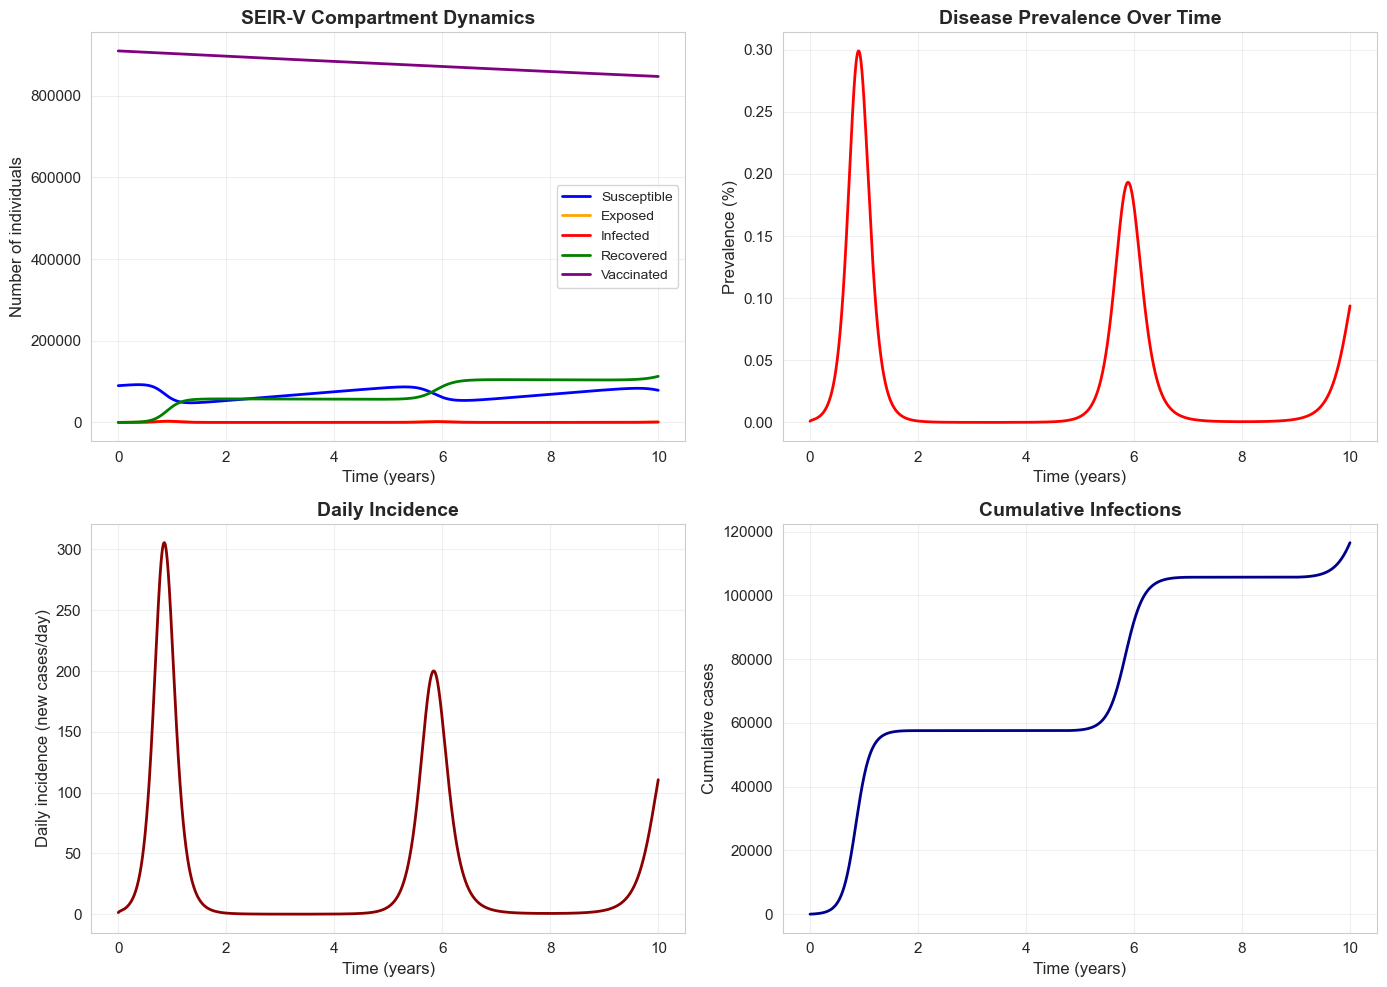

In [3]:
# initialize model with baseline parameters with current vaccination rate
params.initial_vaccinated = params.baseline_coverage_dose1
model_baseline = SEIRVModel(params)

print("Running baseline simulation at current coverage levels:")
results_baseline = model_baseline.simulate(t_max = 365*10)
model_baseline.print_summary()
model_baseline.plot_dynamics()

## Scenario Comparison: Low vaccine coverage (vaccine hesitancy)

Vaccine coverage reduced to 75% (~20% lower)

SEIR-V SIMULATION RESULTS:
Simulation time: 10.0 years
Population size: 1,000,000

--- EPIDEMIC OUTCOMES ---
Total cases: 246,074
Attack rate: 24.61%
Total deaths: 492
Total hospitalizations: 49,215
Peak prevalence: 5.172%
Peak time: 0.27 years

--- FINAL STATE ---
Susceptible: 114,594
Vaccinated: 698,043
Recovered: 228,163
Immune proportion: 92.6%


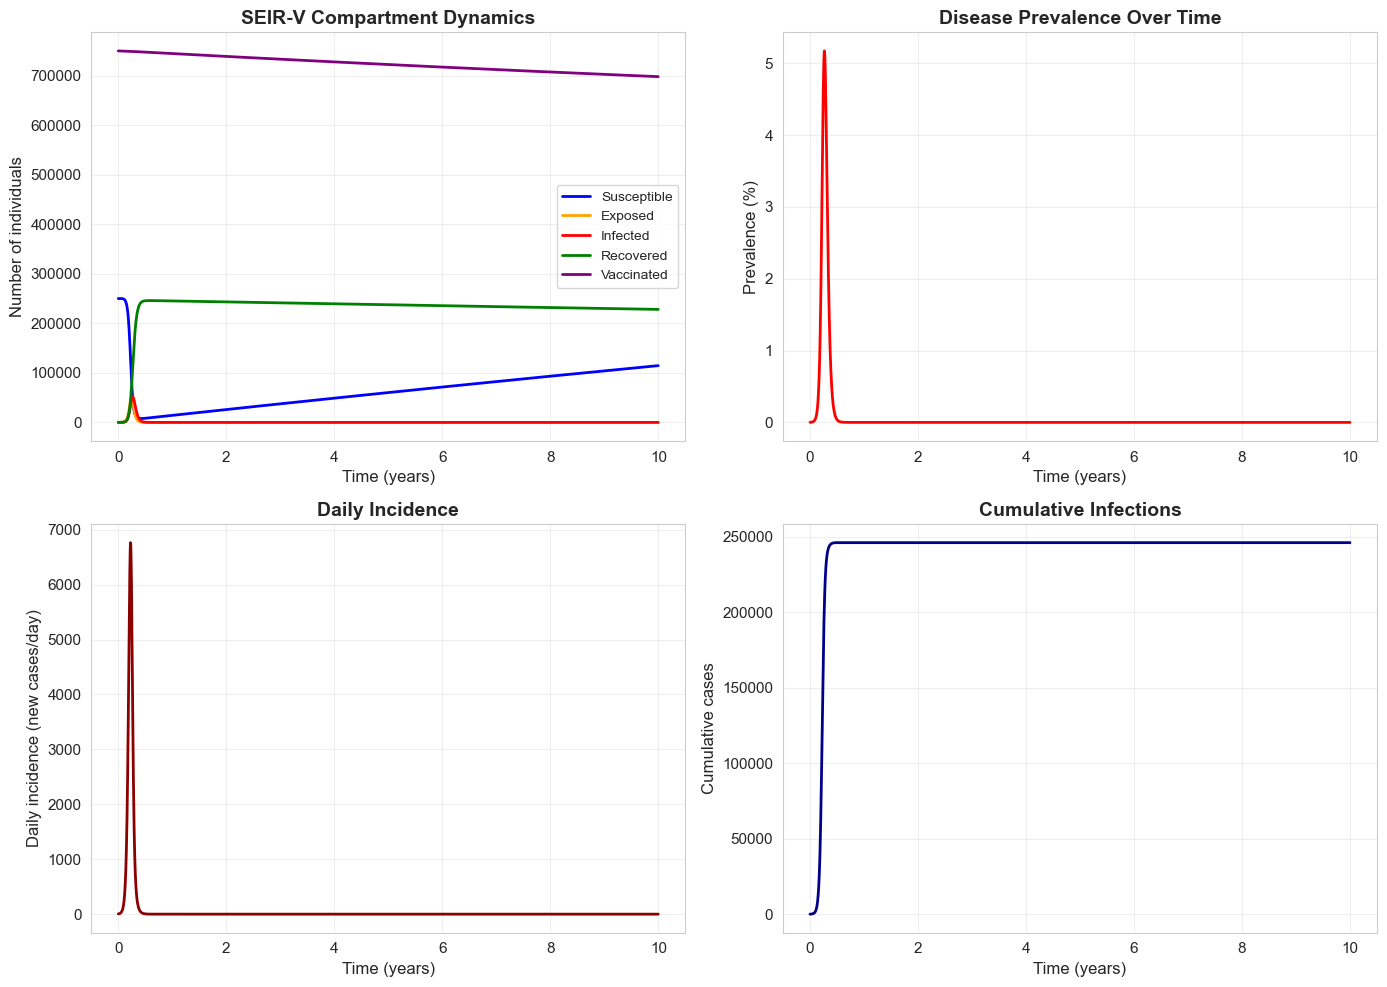

In [4]:
params_low = create_low_coverage_params() 
model_low = SEIRVModel(params_low)
results_low = model_low.simulate(t_max=365*10)
model_low.print_summary()
model_low.plot_dynamics()

### Comparison: Baseline vs. Low Coverage

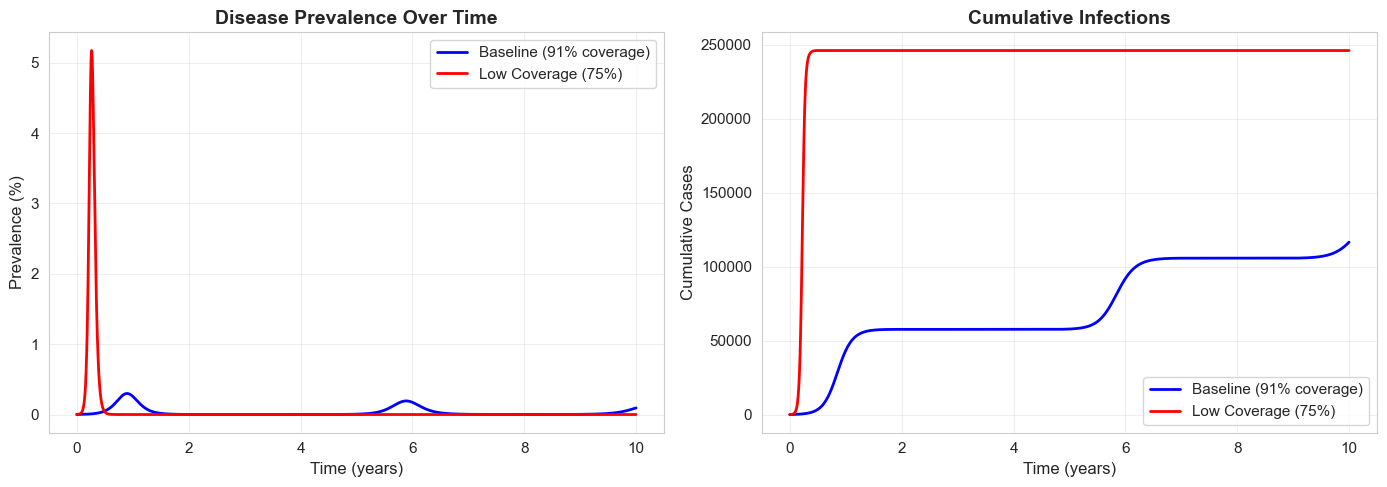


Impact of reducing coverage from 91% → 75%:
  Additional cases: 129,533
  Additional deaths: 259
  Relative increase: 111.1%


In [5]:
# Compare scenarios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Prevalence comparison
ax = axes[0]
ax.plot(results_baseline['time'] / 365, 
        results_baseline['prevalence'] * 100, 
        label='Baseline (91% coverage)', linewidth=2, color='blue')
ax.plot(results_low['time'] / 365, 
        results_low['prevalence'] * 100, 
        label='Low Coverage (75%)', linewidth=2, color='red')
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Prevalence (%)', fontsize=12)
ax.set_title('Disease Prevalence Over Time', fontsize=14, fontweight='bold')
ax.legend(frameon=True, fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Cumulative cases
ax = axes[1]
ax.plot(results_baseline['time'] / 365, 
        results_baseline['cumulative_infections'], 
        label='Baseline (91% coverage)', linewidth=2, color='blue')
ax.plot(results_low['time'] / 365, 
        results_low['cumulative_infections'], 
        label='Low Coverage (75%)', linewidth=2, color='red')
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Cumulative Cases', fontsize=12)
ax.set_title('Cumulative Infections', fontsize=14, fontweight='bold')
ax.legend(frameon=True, fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate differences
outcomes_baseline = model_baseline.calculate_health_outcomes()
outcomes_low = model_low.calculate_health_outcomes()

additional_cases = outcomes_low['total_cases'] - outcomes_baseline['total_cases']
additional_deaths = outcomes_low['total_deaths'] - outcomes_baseline['total_deaths']

print(f"\nImpact of reducing coverage from 91% → 75%:")
print(f"  Additional cases: {additional_cases:,.0f}")
print(f"  Additional deaths: {additional_deaths:,.0f}")
print(f"  Relative increase: {(additional_cases / outcomes_baseline['total_cases'] * 100):.1f}%")

## Cost Effectiveness Analysis

Calculating cost-effectiveness of maintaining high vaccination coverage vs. allowing coverge to drop 

In [6]:
econ = EconomicAnalysis(params)

print("Calculating costs for both scenarios \n")

# baseline scenario costs
costs_baseline = econ.calculate_costs(
    cases=outcomes_baseline['total_cases'],
    deaths=outcomes_baseline['total_deaths'],
    hospitalizations=outcomes_baseline['total_hospitalizations'],
    complications=outcomes_baseline['total_complications'],
    num_vaccinations=outcomes_baseline['final_vaccinated'],
    include_productivity=True
)

# low coverage scenario costs
costs_low = econ.calculate_costs(
    cases=outcomes_low['total_cases'],
    deaths=outcomes_low['total_deaths'],
    hospitalizations=outcomes_low['total_hospitalizations'],
    complications=outcomes_low['total_complications'],
    num_vaccinations=outcomes_low['final_vaccinated'],
    include_productivity=True
)

# calculate ICER (baseline vs. low coverage)
cea_results = econ.calculate_icer(
    intervention_results=outcomes_baseline,
    baseline_results=outcomes_low,
    intervention_costs=costs_baseline,
    baseline_costs=costs_low,
    perspective='societal'
)

econ.print_cea_summary(cea_results)

Calculating costs for both scenarios 

COST-EFFECTIVENESS ANALYSIS RESULTS:

--- HEALTH OUTCOMES ---
Cases averted: 129,533
Deaths averted: 259
DALYs averted: 16,376.5

--- COSTS ---
Baseline costs: $2,230,509,681
Intervention costs: $1,080,146,780
Incremental cost: $-1,150,362,902

--- COST-EFFECTIVENESS ---
Status: DOMINANT STRATEGY (Cost-saving and more effective)


### Cost Breakdown Visualization

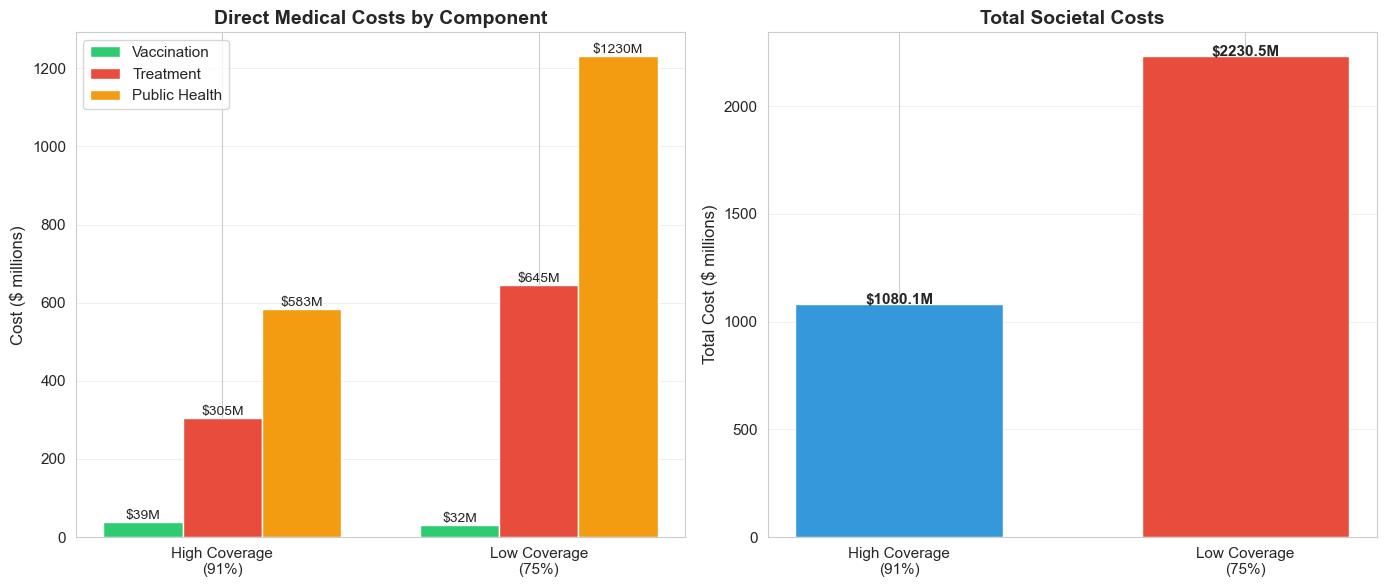


Total savings from maintaining 91% vs 75% coverage: $1150.4 million
  Despite higher vaccination costs: $6.9M
  Avoided treatment costs: $339.4M


In [7]:
# create cost comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Cost components 
ax = axes[0]
scenarios = ['High Coverage\n(91%)', 'Low Coverage\n(75%)']
vaccination = [costs_baseline['vaccination_costs'], costs_low['vaccination_costs']]
treatment = [costs_baseline['treatment_costs'], costs_low['treatment_costs']]
public_health = [costs_baseline['public_health_costs'], costs_low['public_health_costs']]

x = np.arange(len(scenarios))
width = 0.25

bars1 = ax.bar(x - width, np.array(vaccination)/1e6, width, label='Vaccination', color='#2ecc71')
bars2 = ax.bar(x, np.array(treatment)/1e6, width, label='Treatment', color='#e74c3c')
bars3 = ax.bar(x + width, np.array(public_health)/1e6, width, label='Public Health', color='#f39c12')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.0f}M',
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Cost ($ millions)', fontsize=12)
ax.set_title('Direct Medical Costs by Component', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(frameon=True, fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Total costs
ax = axes[1]
total_costs = [costs_baseline['total_costs'], costs_low['total_costs']]
colors = ['#3498db', '#e74c3c']
ax.bar(scenarios, np.array(total_costs)/1e6, color=colors, width=0.6)
ax.set_ylabel('Total Cost ($ millions)', fontsize=12)
ax.set_title('Total Societal Costs', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(total_costs):
    ax.text(i, v/1e6, f'${v/1e6:.1f}M', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate savings
savings = costs_low['total_costs'] - costs_baseline['total_costs']
print(f"\nTotal savings from maintaining 91% vs 75% coverage: ${savings/1e6:.1f} million")
print(f"  Despite higher vaccination costs: ${(costs_baseline['vaccination_costs'] - costs_low['vaccination_costs'])/1e6:.1f}M")
print(f"  Avoided treatment costs: ${(costs_low['treatment_costs'] - costs_baseline['treatment_costs'])/1e6:.1f}M")

## Sensitivity Analysis: Impact of R0

How do results change with different R0 values? (Literature range: 12-18)

In [ ]:
# test range of R0 values
r0_values = np.linspace(12, 18, 7)
coverage_levels = [0.70, 0.80, 0.90, 0.95]

results_sensitivity = {}

for r0 in r0_values:
    for cov in coverage_levels:
        p = MeaslesParameters()
        p.R0 = r0 
        p.baseline_coverage_dose1 = cov 
        p.__post_init__()       # recalculate derived parameters

        # run model
        m = SEIRVModel(p)
        r = m.simulate(t_max=365*10)
        outcomes = m.calculate_health_outcomes()

        # store results
        key = (r0, cov)
        results_sensitivity[key] = outcomes 

print("Sensitivity analysis complete")

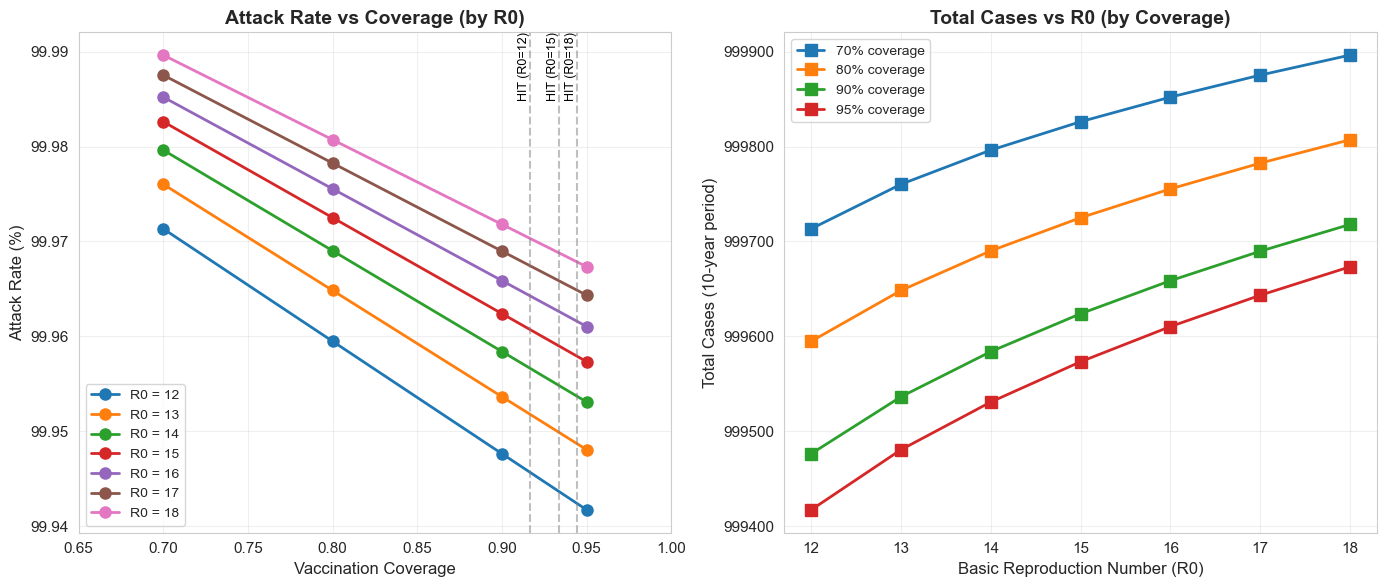

In [ ]:
# visualize sensitivity results
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Plot 1: Attack rate vs. coverage for different R0
ax = axes[0]
for r0 in r0_values:
    attack_rates = [results_sensitivity[(r0, cov)]['attack_rate'] * 100 
                   for cov in coverage_levels]
    ax.plot(coverage_levels, attack_rates, marker='o', linewidth=2, 
            label=f'R0 = {r0:.0f}', markersize=8)

ax.set_xlabel('Vaccination Coverage', fontsize=12)
ax.set_ylabel('Attack Rate (%)', fontsize=12)
ax.set_title('Attack Rate vs Coverage (by R0)', fontsize=14, fontweight='bold')
ax.legend(frameon=True, fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.65, 1.0])

# Add herd immunity threshold line
for r0 in [12, 15, 18]:
    hit = 1 - 1/r0
    ax.axvline(hit, color='gray', linestyle='--', alpha=0.5)
    ax.text(hit, ax.get_ylim()[1], f'HIT (R0={r0:.0f})', 
           rotation=90, va='top', ha='right', fontsize=9, color='k')
    
# Plot 2: Total cases vs R0 for different coverage levels
ax = axes[1]
for cov in coverage_levels:
    total_cases = [results_sensitivity[(r0, cov)]['total_cases'] 
                  for r0 in r0_values]
    ax.plot(r0_values, total_cases, marker='s', linewidth=2, 
            label=f'{cov*100:.0f}% coverage', markersize=8)

ax.set_xlabel('Basic Reproduction Number (R0)', fontsize=12)
ax.set_ylabel('Total Cases (10-year period)', fontsize=12)
ax.set_title('Total Cases vs R0 (by Coverage)', fontsize=14, fontweight='bold')
ax.legend(frameon=True, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Model Validation

Validate the model against empirically-determined measles dynamics: 
- Generation time should be ~latent + infectious period (~18 days)
- Epidemic doubling time with R0 = 15 
- Final size of epidemic in fully susceptible population

MODEL VALIDATION: No Vaccination Scenario

--- FINAL ATTACK RATE ---
Theoretical (1 - 1/R₀): 93.3%
Model result: 100.1%
Difference: 6.72%
Validation: PASS

--- GENERATION TIME ---
Expected (latent + infectious): 18 days
Literature range for measles: 14-21 days
Validation: PASS

--- EPIDEMIC PEAK TIME ---
Theoretical (1/γ × ln(R0)): 27 days
Model result: 42 days
Difference: 15 days
Validation: PASS

--- BASIC REPRODUCTION NUMBER ---
Input parameter R0: 15.0
Estimated R0 from SEIR formula: 14.9
Difference: 0.1
Validation: PASS

--- PEAK PREVALENCE ---
Model result: 36.4%
Expected range for R₀=15.0: 20-40%
Validation: PASS
OVERALL VALIDATION: ALL TESTS PASSED


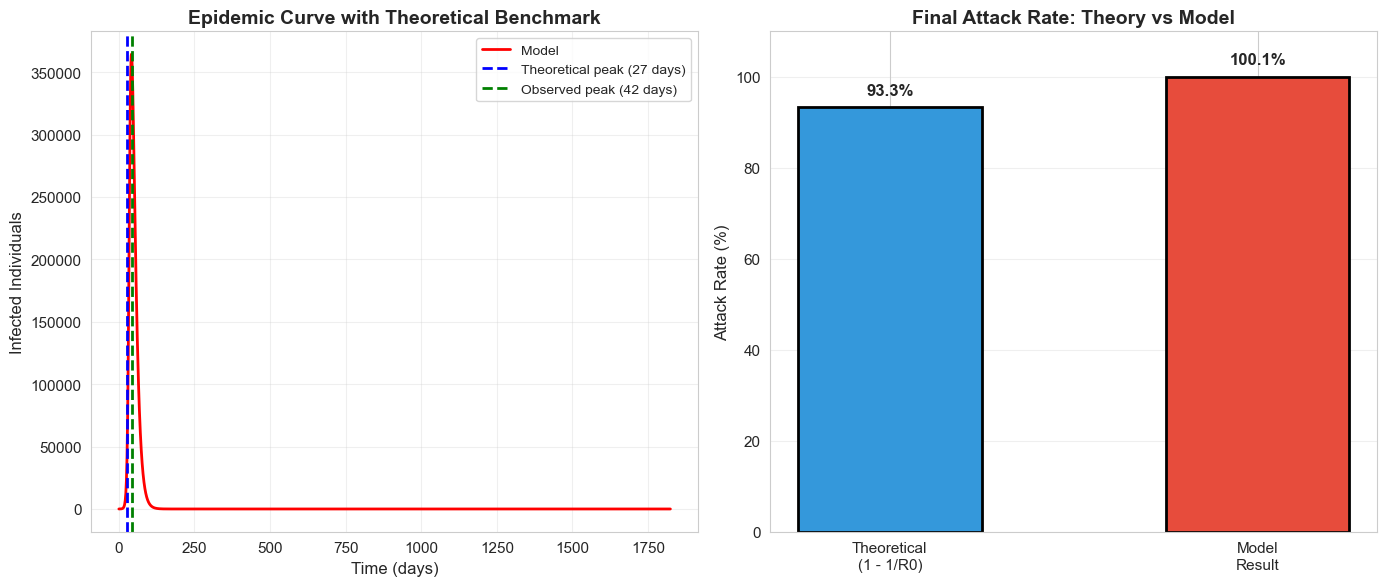

In [ ]:
# validation 1: Epidemic in fully susceptible population (no vaccination)
params_no_vax = MeaslesParameters()
params_no_vax.baseline_coverage_dose1 = 0.0
params_no_vax.baseline_coverage_dose2 = 0.0 
params_no_vax.__post_init__()

model_no_vax = SEIRVModel(params_no_vax)
results_no_vax = model_no_vax.simulate(t_max = 365*5)

outcomes_no_vax = model_no_vax.calculate_health_outcomes()

# THEORETICAL BENCHMARKS
print("MODEL VALIDATION: No Vaccination Scenario")

# 1. Final attack rate (from final size equation)
theoretical_attack_rate = (1 - 1/params.R0) * 100
observed_attack_rate = outcomes_no_vax['attack_rate'] * 100

print(f"\n--- FINAL ATTACK RATE ---")
print(f"Theoretical (1 - 1/R₀): {theoretical_attack_rate:.1f}%")
print(f"Model result: {observed_attack_rate:.1f}%")
print(f"Difference: {abs(theoretical_attack_rate - observed_attack_rate):.2f}%")
validation_1 = "PASS" if abs(theoretical_attack_rate - observed_attack_rate) < 10 else "FAIL"
print(f"Validation: {validation_1}")

# 2. Generation time (serial interval)
generation_time = params.latent_period + params.infectious_period
print(f"\n--- GENERATION TIME ---")
print(f"Expected (latent + infectious): {generation_time:.0f} days")
print(f"Literature range for measles: 14-21 days")
validation_2 = "PASS" if 14 <= generation_time <= 21 else "FAIL"
print(f"Validation: {validation_2}")

# 3. Epidemic peak time
# Approximate formula: t_peak ≈ (1/gamma) * ln(R₀)
theoretical_peak_time = (1/params.gamma) * math.log(params.R0)
observed_peak_time = outcomes_no_vax['peak_time_days']

print(f"\n--- EPIDEMIC PEAK TIME ---")
print(f"Theoretical (1/γ × ln(R0)): {theoretical_peak_time:.0f} days")
print(f"Model result: {observed_peak_time:.0f} days")
print(f"Difference: {abs(theoretical_peak_time - observed_peak_time):.0f} days")
validation_3 = "PASS" if abs(theoretical_peak_time - observed_peak_time) < 15 else "FAIL"
print(f"Validation: {validation_3}")

# 4. Basic reproduction number verification
# for SEIR: R0 = (1 + r/σ)(1 + r/γ). Find exponential growth rate r from early epidemic phase
# early exponential growth phase (after initial lag, before peak), I > 100 but < 10% of peak
peak_id = np.argmax(results_no_vax['I'])
peak_time = results_no_vax['time'][peak_id]
pre_peak_mask = results_no_vax['time'] < (peak_time * 0.5) #first half before the peak
I_growing = results_no_vax['I'][pre_peak_mask]
t_growing = results_no_vax['time'][pre_peak_mask]
early_mask = (I_growing > 100) & (I_growing < 0.1 * np.max(results_no_vax['I']))
I_early = I_growing[early_mask]
t_early = t_growing[early_mask]

if len(I_early) > 10:
    # fit exponential: log(I) = log(I0) + r*t
    log_I = np.log(I_early)
    growth_rate, intercept = np.polyfit(t_early, log_I, 1)

    # check that growth rate is positive
    if growth_rate > 0:
        estimated_R0 = (1 + growth_rate/params.sigma) * (1 + growth_rate/params.gamma)

        print(f"\n--- BASIC REPRODUCTION NUMBER ---")
        print(f"Input parameter R0: {params.R0:.1f}")
        print(f"Estimated R0 from SEIR formula: {estimated_R0:.1f}")
        print(f"Difference: {abs(params.R0 - estimated_R0):.1f}")
        validation_4 = "PASS" if abs(params.R0 - estimated_R0) < 3 else "FAIL"
        print(f"Validation: {validation_4}")
    else:
        print(f"\n--- BASIC REPRODUCTION NUMBER ---")
        print(f"Growth rate is negative ({growth_rate:.4f}) - phase selection failed")
        validation_4 = "SKIP"
else:
    print(f"\n--- BASIC REPRODUCTION NUMBER ---")
    print(f"Insufficient points in early growth phase ({len(I_early)} points)")
    validation_4 = "SKIP"

# 5. Peak prevalence check (should be roughly I_peak ≈ S₀/R₀ for simple SIR)
# For SEIR it's a bit more complex, but should be in similar range
peak_prevalence_pct = outcomes_no_vax['peak_prevalence'] * 100
print(f"\n--- PEAK PREVALENCE ---")
print(f"Model result: {peak_prevalence_pct:.1f}%")
print(f"Expected range for R₀={params.R0}: 20-40%")
validation_5 = "PASS" if 20 <= peak_prevalence_pct <= 40 else "FAIL"
print(f"Validation: {validation_5}")

all_pass = all([v == "PASS" for v in [validation_1, validation_2, validation_3, validation_4, validation_5]])
print(f"OVERALL VALIDATION: {'ALL TESTS PASSED' if all_pass else 'SOME TESTS FAILED'}")

# Enhanced visualization with theoretical benchmarks
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Epidemic curve with annotations
ax = axes[0]
ax.plot(results_no_vax['time'], results_no_vax['I'], linewidth=2, color='red', label='Model')
ax.axvline(theoretical_peak_time, color='blue', linestyle='--', linewidth=2, 
           label=f'Theoretical peak ({theoretical_peak_time:.0f} days)')
ax.axvline(observed_peak_time, color='green', linestyle='--', linewidth=2, 
           label=f'Observed peak ({observed_peak_time:.0f} days)')
ax.set_xlabel('Time (days)', fontsize=12)
ax.set_ylabel('Infected Individuals', fontsize=12)
ax.set_title('Epidemic Curve with Theoretical Benchmark', fontsize=14, fontweight='bold')
ax.legend(frameon=True, fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Final size comparison
ax = axes[1]
categories = ['Theoretical\n(1 - 1/R0)', 'Model\nResult']
values = [theoretical_attack_rate, observed_attack_rate]
colors = ['#3498db', '#e74c3c']
bars = ax.bar(categories, values, color=colors, width=0.5, edgecolor='black', linewidth=2)
ax.set_ylabel('Attack Rate (%)', fontsize=12)
ax.set_title('Final Attack Rate: Theory vs Model', fontsize=14, fontweight='bold')
ax.set_ylim([0, 110])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Create summary table
summary_data = {
    'Scenario': ['High Coverage (91%)', 'Low Coverage (75%)', 'No Vaccination'],
    'Total Cases': [
        f"{outcomes_baseline['total_cases']:,.0f}",
        f"{outcomes_low['total_cases']:,.0f}",
        f"{outcomes_no_vax['total_cases']:,.0f}"
    ],
    'Deaths': [
        f"{outcomes_baseline['total_deaths']:,.0f}",
        f"{outcomes_low['total_deaths']:,.0f}",
        f"{outcomes_no_vax['total_deaths']:,.0f}"
    ],
    'Attack Rate (%)': [
        f"{outcomes_baseline['attack_rate']*100:.2f}",
        f"{outcomes_low['attack_rate']*100:.2f}",
        f"{outcomes_no_vax['attack_rate']*100:.2f}"
    ],
    'Total Costs ($M)': [
        f"{costs_baseline['total_costs']/1e6:.1f}",
        f"{costs_low['total_costs']/1e6:.1f}",
        "N/A"
    ]
}

df_summary = pd.DataFrame(summary_data)
print("SCENARIO COMPARISON SUMMARY (10-year horizon)")
print("=" * 70)
print(df_summary.to_string(index=False))


SCENARIO COMPARISON SUMMARY (10-year horizon)
           Scenario Total Cases Deaths Attack Rate (%) Total Costs ($M)
High Coverage (91%)     116,541    233           11.65           1080.1
 Low Coverage (75%)     246,074    492           24.61           2230.5
     No Vaccination   1,000,535  2,001          100.05              N/A
